In [1]:
import numpy as np, matplotlib.pyplot as plt
from numpy import *
import pylab
import scipy as scipy
from scipy.io import wavfile
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
import IPython
import cmath

# Helper functions from lab1

In [2]:
def stft(input_sound, dft_size, hop_size, zero_pad, window):

    # Forward tranform
    if(input_sound.ndim is 1):
        # Zero Pad the signal
        length_input_sound = len(input_sound)
        remainder = (length_input_sound - dft_size)%hop_size
        padded_input = append(input_sound,zeros(hop_size-remainder))
        padded_input = append(zeros(dft_size), padded_input)

        # Calculcate FFTs using analysis(hamming) window
        X = np.array([np.fft.rfft(window*padded_input[i:i+dft_size], dft_size + zero_pad) 
                        for i in range(0, len(padded_input)-dft_size+1, hop_size)])
        X = X.T
        
        return X
        
    # Inverse transform
    else:
        #Restore original shape
        waveform = np.zeros(dft_size + (input_sound.shape[1]-1)*hop_size)
        X = input_sound.T
        
        for n,i in enumerate(range(0, len(waveform)-dft_size-zero_pad+1, hop_size)):
            waveform[i:i+dft_size+zero_pad] += np.real(np.fft.irfft(X[n]))
            
        for i in range(0, len(waveform)-dft_size + 1, hop_size):
            waveform[i:i+dft_size] = waveform[i:i+dft_size]
        
        return waveform
    
def plot_spec(X, dft_size, hop_size, samplerate):  
    
    freq = np.arange(0, X.shape[1])
    
    plt.pcolormesh(np.linspace(0, (dft_size + (hop_size)*(X.shape[1]-1))/samplerate, X.shape[1]), np.linspace(0, 1, X.shape[0]), abs(X)**0.4)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.show()

# Awesome Helper functions created

In [3]:
def initialize(sound, dft_size, hop_size, zero_pad, window):
    IPython.display.display(IPython.display.Audio(sound, rate=samplerate))
    window = np.hanning(dft_size)
    Zxx = stft(sound, dft_size, hop_size, zero_pad, window)
    plot_spec(Zxx, dft_size, hop_size, samplerate)
    
    return Zxx

In [4]:
def getNoiseProfile(Zxx_noise):
    noise_profile = np.zeros(Zxx_noise.shape[0], dtype = complex_)
    noise_profile = np.mean(np.abs(Zxx_noise), axis = 1)
    plt.plot(noise_profile)
    plt.show()
    return noise_profile

In [5]:
def spectralSubtraction(Zxx, alpha, noise_profile):
    final_spectrogram = np.zeros(Zxx.shape, dtype = complex_)
    for i in range(Zxx.shape[1]):
        phase = np.angle(Zxx[:, i])
        computed = np.abs(Zxx[:, i]) - alpha*(noise_profile)
        for j in range(len(computed)):
            if computed[j]<0:
                computed[j] = 0
        final_spectrogram[:, i] = computed
    return final_spectrogram

In [6]:
def applyPhase(Zxx, final_spectrogram):
    spectrogram = np.zeros(Zxx.shape, dtype = complex_)
    for i in range(Zxx.shape[1]):
        phase = np.angle(Zxx[:, i])
        exponent = np.exp(1j*phase)
        spectrogram[:, i] = np.multiply(final_spectrogram[:,i], exponent) 
        
    return spectrogram

# Room Speech

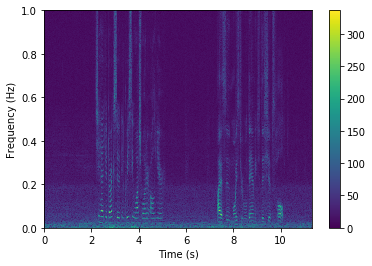

In [37]:
samplerate, sound = wavfile.read('room-speech.wav')


dft_size = 1024
hop_size = 256
zero_pad = 0

window = np.hanning(dft_size)

Zxx = initialize(sound, dft_size, hop_size, zero_pad, window)

## Extract noise and exhibit magnitude

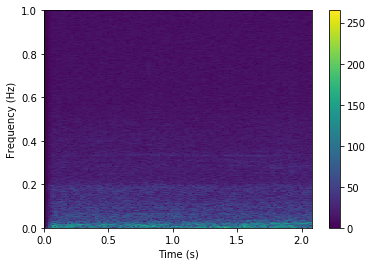

In [38]:
noise = sound[:samplerate*2]
IPython.display.display(IPython.display.Audio(noise, rate=samplerate))
Zxx_noise = stft(noise, dft_size, hop_size, zero_pad, window)
plot_spec(Zxx_noise, dft_size, hop_size, samplerate)

## Create noise profile

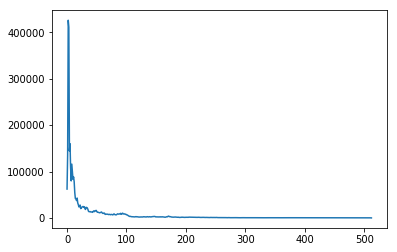

In [39]:
noise_profile = getNoiseProfile(Zxx_noise)

## Spectral subtraction

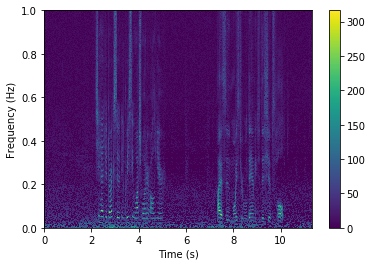

In [40]:
Zxx = stft(sound, dft_size, hop_size, zero_pad, window)
alpha = 0.7

final_spectrogram = spectralSubtraction(Zxx, alpha, noise_profile)

plot_spec(final_spectrogram, dft_size, hop_size, samplerate)

## Apply Median filtering to minimize musical noise 

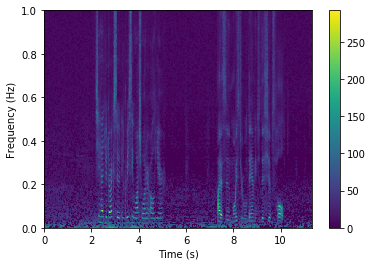

In [41]:
final_spectrogram = signal.medfilt2d(np.abs(final_spectrogram), [3,3])
plot_spec(final_spectrogram, dft_size, hop_size, samplerate)

## Incorporate for phase and return to time domain

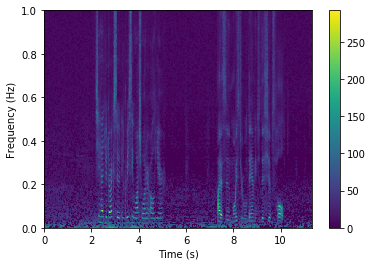

In [42]:
spectrogram = applyPhase(Zxx, final_spectrogram)
plot_spec(spectrogram, dft_size, hop_size, samplerate)

filtered_sound = stft(spectrogram, dft_size, hop_size, zero_pad, window)
IPython.display.display(IPython.display.Audio(filtered_sound, rate=samplerate))

# Air communication

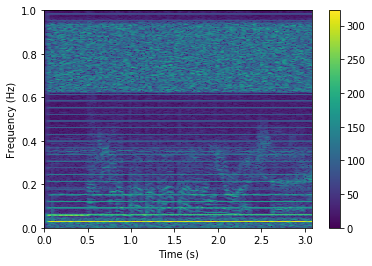

In [146]:
samplerate, sound = wavfile.read('aircomm.wav')

dft_size = 1024
hop_size = 128
zero_pad = 0
window = np.hanning(dft_size)

Zxx = initialize(sound, dft_size, hop_size, zero_pad, window)

## Extract noise and exhibit magnitude

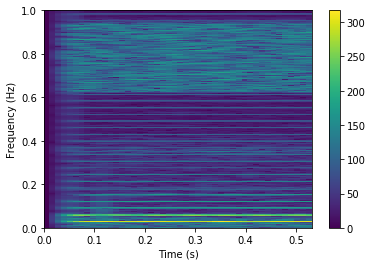

In [147]:
noise = sound[:int(samplerate*0.45)]
IPython.display.display(IPython.display.Audio(noise, rate=samplerate))
Zxx_noise = stft(noise, dft_size, hop_size, zero_pad, window)
plot_spec(Zxx_noise, dft_size, hop_size, samplerate)

## Create noise profile

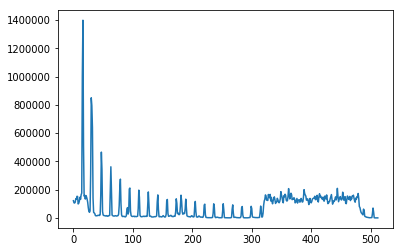

In [148]:
noise_profile = getNoiseProfile(Zxx_noise)

## Subtract noise and nullify negative

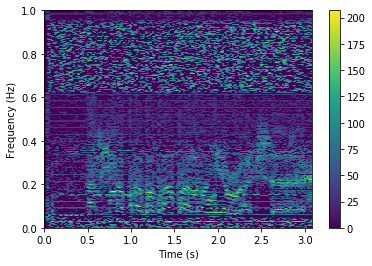

In [149]:
Zxx = stft(sound, dft_size, hop_size, zero_pad, window)
alpha = 1

final_spectrogram = spectralSubtraction(Zxx, alpha, noise_profile)
plot_spec(final_spectrogram, dft_size, hop_size, samplerate)

## Apply Median filtering to minimize musical noise 

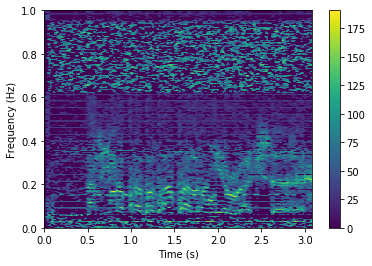

In [150]:
final_spectrogram = signal.medfilt2d(np.abs(final_spectrogram), [3,3])
plot_spec(final_spectrogram, dft_size, hop_size, samplerate)

## Incorporate for phase and return to time domain

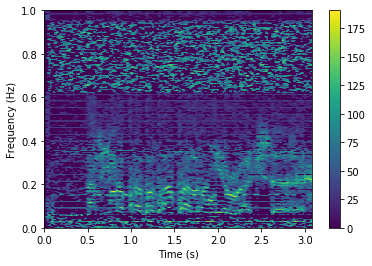

In [151]:
spectrogram = applyPhase(Zxx, final_spectrogram)
plot_spec(spectrogram, dft_size, hop_size, samplerate)

filtered_sound = stft(spectrogram, dft_size, hop_size, zero_pad, window)
IPython.display.display(IPython.display.Audio(filtered_sound, rate=samplerate))

# Wind Speech

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


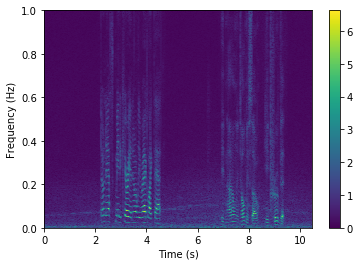

In [152]:
samplerate, sound = wavfile.read('wind-speech.wav')

dft_size = 2048
hop_size = 128
zero_pad = 0
window = np.hanning(dft_size)

Zxx = initialize(sound, dft_size, hop_size, zero_pad, window)

## Extract noise and exhibit magnitude

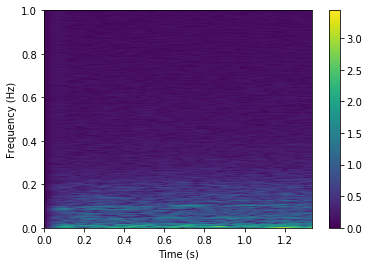

In [153]:
noise = sound[int(samplerate*5):int(samplerate*6.2)]
IPython.display.display(IPython.display.Audio(noise, rate=samplerate))
Zxx_noise = stft(noise, dft_size, hop_size, zero_pad, window)
plot_spec(Zxx_noise, dft_size, hop_size, samplerate)

## Create noise profile

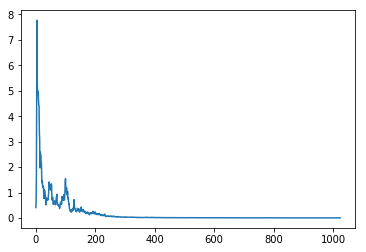

In [154]:
noise_profile = getNoiseProfile(Zxx_noise)

## Subtract noise and nullify negative

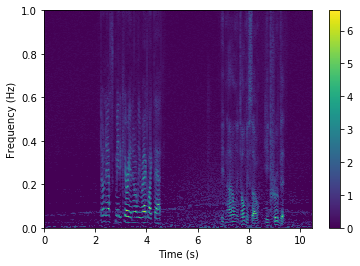

In [168]:
Zxx = stft(sound, dft_size, hop_size, zero_pad, window)

alpha = 1

final_spectrogram = spectralSubtraction(Zxx, alpha, noise_profile)
plot_spec(final_spectrogram, dft_size, hop_size, samplerate)

## Apply Median filtering to minimize musical noise 

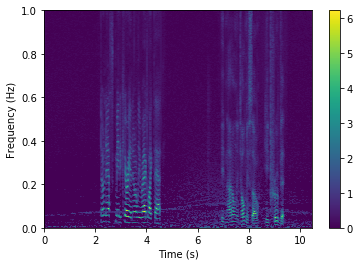

In [169]:
final_spectrogram = signal.medfilt2d(np.abs(final_spectrogram), [3,3])
plot_spec(final_spectrogram, dft_size, hop_size, samplerate)

## Incorporate for phase and return to time domain

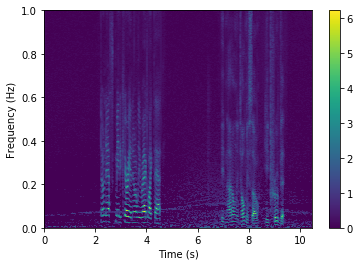

In [170]:
spectrogram = applyPhase(Zxx, final_spectrogram)
plot_spec(spectrogram, dft_size, hop_size, samplerate)

filtered_sound = stft(spectrogram, dft_size, hop_size, zero_pad, window)
IPython.display.display(IPython.display.Audio(filtered_sound, rate=samplerate))

# Final Note

### After Experimentation, I found out that alpha defines the tradeoff between how much noise you want to remove vs how "musical" it will become. Also, bigger windows work better here because our aim is to retain a better frequency resolution, which we learnt from lab1 is better when the window size is bigger(Time-Frequency compromise). As for the Kernel for median filter, bigger kernel filters start to distort the sound very fast, so I've gone with a small 3*3 kernel.